In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# User settings
Specify the list of countries, using names used in the SPLAT Energy Supply model 

In [2]:
countries = ['Angola', 'Botswana', 'DemocraticRepublicoftheCongo', 'Eswatini', 'Lesotho',
             'Malawi', 'Mozambique', 'Namibia', 'SouthAfrica', 'UnitedRepublicofTanzania', 'Zambia',
             'Zimbabwe']

# Load data
When saving the data in your `input` folder, we recommend to do the following:
- filter the excel to the countries of interest to you to reduce size
- save the data as `.csv` instead of `.xlsx` to improve performance when loading the data

For each country, clusters with the best resources for wind and solar have been identified. They are included in the data, with their corresponding latitude, longitude, theoretical capacity (MW), corresponding LCOE (taking into consideration resource quality but also distance to load and grid), and hourly profile for the year 2018.
To obtain hourly profiles for other years, the whole open-source code should be rerun. Refer to their [Github repo](https://github.com/SPLATteam/Model-Supply-Regions-MSR-Toolset/tree/main) and to the [article](https://www.nature.com/articles/s41597-022-01786-5) for more information.

In [3]:
file_solarMSR = os.path.join('input', 'SolarPV_BestMSRsToCover5%CountryArea.csv')
if not os.path.exists(file_solarMSR):
    raise FileNotFoundError(f"The file {file_solarMSR} does not exist. Please download the Solar PV MSR data and place it in the input folder.")
else:
    print(f"File {file_solarMSR} found. Proceeding with the analysis.")

File input/SolarPV_BestMSRsToCover5%CountryArea.csv found. Proceeding with the analysis.


In [4]:
file_windMSR = os.path.join('input', 'Wind_BestMSRsToCover5%CountryArea.csv')
if not os.path.exists(file_windMSR):
    raise FileNotFoundError(f"The file {file_windMSR} does not exist. Please download the Solar PV MSR data and place it in the input folder.")
else:
    print(f"File {file_windMSR} found. Proceeding with the analysis.")

File input/Wind_BestMSRsToCover5%CountryArea.csv found. Proceeding with the analysis.


# Process data
Extract average LCOE, CF, and hourly profiles for each country

In [5]:
# We define capex parameters used in their model
# They use a discount rate of 10%, and lifetime of 25 years for generation, 40 years for transmission
CAPEX_PARAMETERS = {
    'solar': {
        'supply_asset_capital_recovery': 0.1101681,
        'operating_costs': 4,
        'fixed_costs': 53500
    },
    'wind': {
        'supply_asset_capital_recovery': 0.1101681,
        'operating_costs': 0,
        'fixed_costs': 64200
    },
    'grid': {
        'supply_asset_capital_recovery': 0.102259,
    },
    'road': {
        'supply_asset_capital_recovery': 0.11017,
    }
}


def compute_weighted_stats(group, tech):
    """Weighted statistics across all relevant clusters for a given country. We use the theoretical available capacity in a given cluster as the weight."""
    avg_cf = (group[column_cf] * group['CapacityMW']).sum() / group['CapacityMW'].sum()  # MWh / MW
    avg_lcoe = (group['LCOE-MWh'] * group['CapacityMW']).sum() / group['CapacityMW'].sum()  # $ / MWh
    # For the LCOE, we use the breakdown of the LCOE into different components (generation, road and transmission), and the capital recovery rates used in the MSR model
    cost_per_MW = ((((group['sLCOE-MWh'] - CAPEX_PARAMETERS[tech]['operating_costs'])  * (8760 * group[column_cf] / 100) - CAPEX_PARAMETERS[tech]['fixed_costs']) / CAPEX_PARAMETERS[tech]['supply_asset_capital_recovery'] + (group['tLCOE-MWh']  * (8760 * group[column_cf] / 100)) / CAPEX_PARAMETERS['grid']['supply_asset_capital_recovery'] + (group['rLCOE-MWh']  * (8760 * group[column_cf] / 100)) / CAPEX_PARAMETERS['road']['supply_asset_capital_recovery'])  * group['CapacityMW']).sum() / group['CapacityMW'].sum()  * 1e-6  # costs in m$ / MW
    
    return pd.Series({
        'avg_CF': avg_cf,
        'avg_LCOE': avg_lcoe,
        'cost_per_MW': cost_per_MW
    })


# Weighted hourly profile for each country
def weighted_hourly_profile(group):
    weights = group['CapacityMW'].values.reshape(-1, 1)
    hourly_data = group[hourly_cols].values
    weighted_avg = (hourly_data * weights).sum(axis=0) / weights.sum()
    return pd.Series(weighted_avg, index=hourly_cols)


In [18]:
cf_lcoe_stats = {}
hourly_profiles = {}

for tech in ['wind', 'solar']:
    if tech == 'wind':
        file = file_windMSR 
        column_cf = 'CF100m'
    else:
        file = file_solarMSR
        column_cf = 'CF'

    # Select relevant columns
    meta_cols = ['CtryName', 'CapacityMW', column_cf, 'sLCOE-MWh', 'tLCOE-MWh', 'rLCOE-MWh', 'LCOE-MWh']
    hourly_cols = [f'H{i}' for i in range(1, 8761)]  # if needed

    # Combine what you need
    use_columns = meta_cols + hourly_cols  # or just meta_cols to start
    
    data_MSR_stats = pd.read_csv(file, usecols=use_columns, header=0)
    data_MSR_stats = data_MSR_stats[data_MSR_stats['CtryName'].isin([c for c in countries])]
    
    cf_lcoe_stats[tech] = data_MSR_stats.groupby('CtryName').apply(compute_weighted_stats, tech=tech).reset_index()
    
    data_MSR_hourlyprofile = data_MSR_stats.set_index(['CtryName', 'CapacityMW'])[hourly_cols].reset_index()
    hourly_profiles[tech] = data_MSR_hourlyprofile.groupby('CtryName').apply(weighted_hourly_profile).reset_index()
    
    date_index = pd.date_range(start='2023-01-01', periods=8760, freq='H')  # 2023 is a non-leap year

    df_long = hourly_profiles[tech].melt(id_vars='CtryName', var_name='Hour', value_name='value')
    
    # Step 3: Convert 'H1', ..., 'H8760' to integer hour index
    df_long['hour_index'] = df_long['Hour'].str.extract('H(\d+)').astype(int) - 1  # zero-based index
    
    df_long['timestamp'] = df_long['hour_index'].map(lambda i: date_index[i])
    df_long['season'] = df_long['timestamp'].dt.month
    df_long['day'] = df_long['timestamp'].dt.day
    df_long['hour'] = df_long['timestamp'].dt.hour
    
    # Step 5: Rename and index
    df_long = df_long.rename(columns={'CtryName': 'zone'})
    df_final = df_long.set_index(['zone', 'season', 'day', 'hour'])['value']
    
    df_final.to_frame().rename(columns={'value': 2018}).to_csv(os.path.join('output', f'data_SAPP_{tech}.csv'), index=True)

<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
/var/folders/q1/q3sbpxn50b5frhgsdn1cq0z80000gn/T/ipykernel_15581/4037936553.py:32: SyntaxWarning: invalid escape sequence '\d'
  df_long['hour_index'] = df_long['Hour'].str.extract('H(\d+)').astype(int) - 1  # zero-based index
/var/folders/q1/q3sbpxn50b5frhgsdn1cq0z80000gn/T/ipykernel_15581/4037936553.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cf_lcoe_stats[tech] = data_MSR_stats.groupby('CtryName').apply(compute_weighted_stats, tech=tech).reset_index()
/var/folders/q1/q3sbpxn50b5frhgsdn1cq0z80000gn/T/ipykernel_15581/4037936553.py:25: DeprecationWarning: DataFrameGroupBy.apply operated 

In [19]:
cf_lcoe_stats['solar']

,CtryName,avg_CF,avg_LCOE,cost_per_MW
0,Angola,20.663166,107.695150,1.226173e+06
1,Botswana,20.329495,107.616639,1.196085e+06
2,DemocraticRepublicoftheCongo,17.843495,126.198877,1.257036e+06
3,Eswatini,17.158789,126.289381,1.189615e+06
4,Lesotho,19.642771,109.975881,1.175416e+06
5,Malawi,19.630909,112.302706,1.213454e+06
6,Mozambique,18.419469,118.139140,1.192408e+06
7,Namibia,21.542836,101.920212,1.198083e+06
8,SouthAfrica,20.851198,104.303855,1.183791e+06
9,UnitedRepublicofTanzania,20.728033,106.331051,1.207338e+06


# Plots

In [56]:
tech = 'solar'

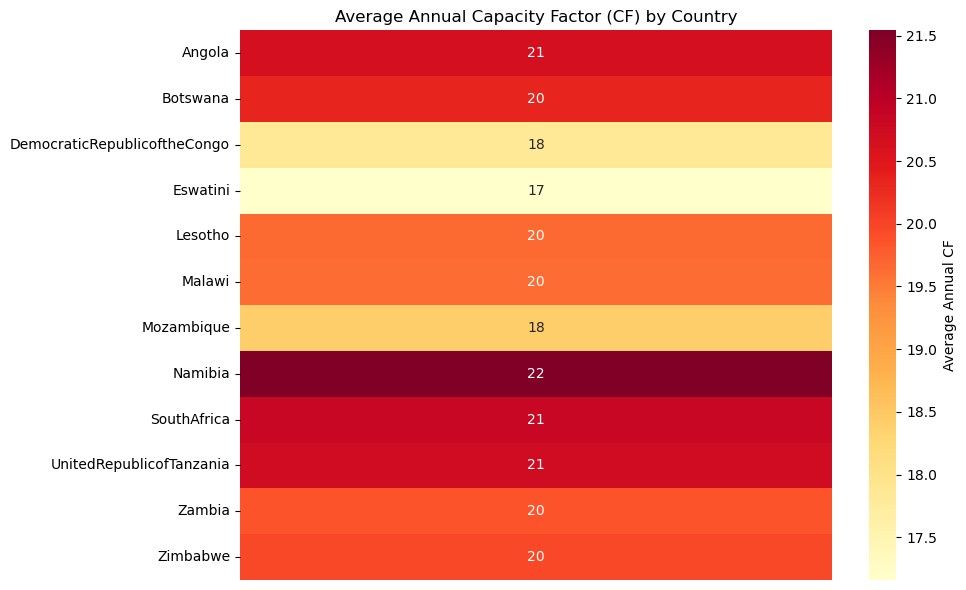

In [57]:
# Heatmap: average annual CF by country
cf_lcoe_stats_pivot = cf_lcoe_stats[tech].set_index('CtryName')[['avg_CF']]

plt.figure(figsize=(10, 6))
sns.heatmap(cf_lcoe_stats_pivot, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Average Annual CF'})
plt.title('Average Annual Capacity Factor (CF) by Country')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.show()

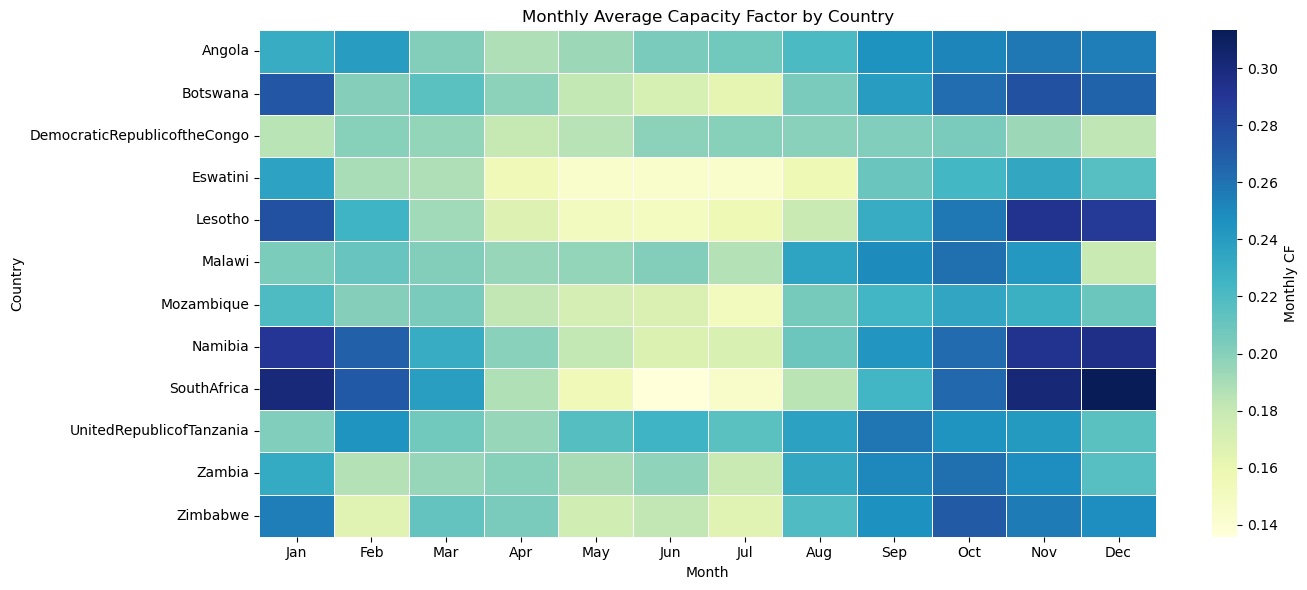

In [58]:
# Function to approximate monthly CF from 8760-hour profile
def approximate_monthly_cf(hourly_row):
    hours_per_month = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]  # hours/month
    monthly_cf = []
    cursor = 0
    for h in hours_per_month:
        monthly_cf.append(hourly_row[cursor:cursor+h].mean())
        cursor += h
    return monthly_cf

# Build monthly CF dataframe from hourly_profiles
monthly_cf_dict = {}
for _, row in hourly_profiles[tech].iterrows():
    country = row['CtryName']
    hourly_values = row.drop('CtryName').astype(float).values
    monthly_cf_dict[country] = approximate_monthly_cf(hourly_values)

monthly_cf_df = pd.DataFrame.from_dict(monthly_cf_dict, orient='index',
                                       columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(monthly_cf_df, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Monthly CF'})
plt.title('Monthly Average Capacity Factor by Country')
plt.ylabel('Country')
plt.xlabel('Month')
plt.tight_layout()
plt.show()
